In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import graphviz

import numpy as np
import networkx as nx


In [2]:
#Treat dataset

#Import data 
# data = pd.read_csv('../datasets/consolidated.csv',header=0, index_col=0)
data = pd.read_csv('../../../Datasets/Networkwise/consolidated_5s.csv',header=0, index_col=0)
consolidated = pd.DataFrame(data)


consolidated = consolidated.drop(columns=['experiment', 'topology'])#, 'messageBandwidth'])#, 'gossipBandwidth'])#, 'messageDuplicated'])#, 'n_nodes', 'consensus', 'messageDuplicated'])
# consolidated = consolidated.loc[consolidated['totalBandwidth'] > 0]
# consolidated.head(100)

consolidateddiff = consolidated.dropna().dropna()

X = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']].to_numpy()
df = consolidateddiff[['d', 'messageReceived', 'graft', 'prune', 'dlo', 'dhi', 'dout', 'interval', 'messageOverhead', 'topics', 'topicSize']]

df.head(500)

,d,messageReceived,graft,prune,dlo,dhi,dout,interval,messageOverhead,topics,topicSize
0,8,43.0,0.0,0.0,6,12,2,1.0,321.0,1,16
1,8,54.0,0.0,0.0,6,12,2,1.0,389.0,1,16
2,8,96.0,0.0,0.0,6,12,2,1.0,702.0,1,16
3,8,88.0,0.0,0.0,6,12,2,1.0,629.0,1,16
4,8,61.0,0.0,0.0,6,12,2,1.0,454.0,1,16
...,...,...,...,...,...,...,...,...,...,...,...
495,16,18.0,0.0,0.0,8,20,4,0.5,62.0,1,16
496,16,56.0,0.0,0.0,8,20,4,0.5,250.0,1,16
497,16,50.0,0.0,0.0,8,20,4,0.5,175.0,1,16
498,16,58.0,0.0,0.0,8,20,4,0.5,239.0,1,16


In [3]:
causal_graph = nx.read_adjlist("../../../1_Discovery/MessageOverhead/NetworkWise/intersection.adjlist", create_using=nx.DiGraph)
consolidatedDiff = consolidated.dropna()#.diff().dropna()

gml_graph = "\n".join(nx.generate_gml(causal_graph))

print(gml_graph)

graph [
  directed 1
  node [
    id 0
    label "dhi"
  ]
  node [
    id 1
    label "messageOverhead"
  ]
  node [
    id 2
    label "prune"
  ]
  node [
    id 3
    label "dout"
  ]
  node [
    id 4
    label "graft"
  ]
  node [
    id 5
    label "messageReceived"
  ]
  node [
    id 6
    label "topicSize"
  ]
  node [
    id 7
    label "dlo"
  ]
  node [
    id 8
    label "interval"
  ]
  node [
    id 9
    label "d"
  ]
  node [
    id 10
    label "topics"
  ]
  edge [
    source 0
    target 1
  ]
  edge [
    source 0
    target 2
  ]
  edge [
    source 2
    target 1
  ]
  edge [
    source 3
    target 4
  ]
  edge [
    source 3
    target 1
  ]
  edge [
    source 4
    target 5
  ]
  edge [
    source 4
    target 1
  ]
  edge [
    source 5
    target 1
  ]
  edge [
    source 6
    target 2
  ]
  edge [
    source 6
    target 4
  ]
  edge [
    source 7
    target 1
  ]
  edge [
    source 8
    target 4
  ]
  edge [
    source 8
    target 2
  ]
  edge [
   

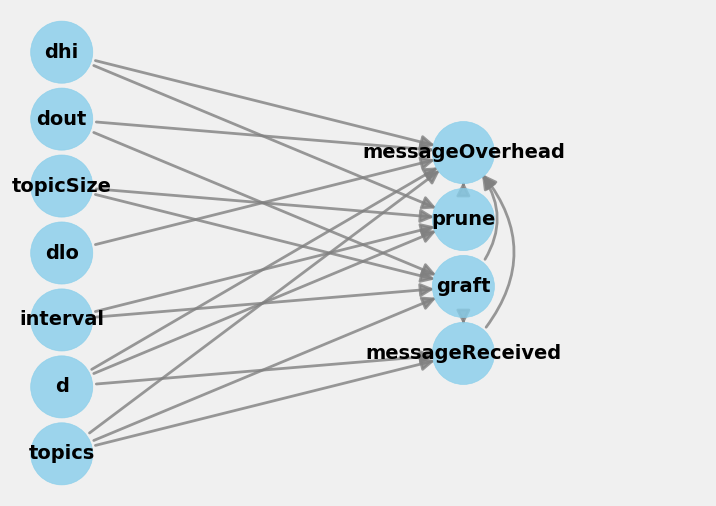

In [4]:
# With graph
model = CausalModel(
    data=df,
    treatment='d',
    outcome='messageOverhead',
    graph=gml_graph
)
model.view_model()

In [5]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                      
────(E[messageOverhead])
d[d]                    
Estimand assumption 1, Unconfoundedness: If U→{d} and U→messageOverhead then P(messageOverhead|d,,U) = P(messageOverhead|d,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.DML',
    method_params={
        'init_params': {
            'model_y': GradientBoostingRegressor(),
            'model_t': GradientBoostingRegressor(),
            'model_final': LassoCV(fit_intercept=False),
        },
        'fit_params': {}}
)

print(f'Estimate of causal effect (DML): {estimate.value}')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Estimate of causal effect (DML): 35.04659650936198


In [7]:
estimate_lr = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.linear_regression')

print(f'Estimate of causal effect (linear regression): {estimate_lr.value}')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Estimate of causal effect (linear regression): 8.994586843829836


In [ ]:
random_cause = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause'
)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

In [ ]:
print(random_cause)

In [ ]:
placebo_refuter = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter'
)

In [ ]:
print(placebo_refuter)